In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting

torch.manual_seed(1) # set the random seed

class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 30)
        self.layer2 = nn.Linear(30, 1)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2

# load the data
mnist_train = datasets.MNIST('data', train=True, download=True)
mnist_train = list(mnist_train)[:2000]
img_to_tensor = transforms.ToTensor()

# create a new model, initialize random parameters
pigeon = Pigeon()

# loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(pigeon.parameters(), lr=0.005, momentum=0.9)

# training
for (image, label) in mnist_train[:1000]:
    # actual ground truth: is the digit less than 3?
    actual = (label < 3).reshape([1,1]).type(torch.FloatTensor)
    # prediction
    out = pigeon(img_to_tensor(image))
    # update the parameters based on the loss
    loss = criterion(out, actual) # compute the loss
    loss.backward()               # compute updates for each parameter
    optimizer.step()              # make the updates for each parameter
    optimizer.zero_grad()         # a clean up step for PyTorch

C:\Users\User\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


AttributeError: 'bool' object has no attribute 'reshape'

Batching
Let's break down the training code again a little more. At each iteration of the main training loop, we:

we use our network to make the predictions for one image
we compute the loss for that one image
we take a "step" to optimize the loss of that one image
In a biological setting, it makes sense to ask real pigeons to reason about one image at a time. However, with an artificial neural network, we may want to use more than one image at one time. That way, we can compute the average loss across a mini-batch of multiple images, and take a step to optimize the average loss. The average loss across multiple training inputs is going to be less "noisy" than the loss for a single input, and is less likely to provide "bad information" because of a "bad" input.

So, we are going to do the following at each iteration:

we use our network to make the predictions for  n  images
we compute the average loss for those  n  images
we take a "step" to optimize the average loss of those  n  images
The number  n  is called the batch size.

In one extreme, we can set  n=1 , as we have done above. However, having such a small batch size means that we might be optimizing a very different loss function in each iteration. The "steps" that we make might cause our parameters to change in different directions. Training might therefore take longer because of the noisiness.

In the other extreme, we can set  n  to be the size of our training set. We would be computing the average loss for our entire training set at every iteration. When we have a small training set, this strategy might be feasible. When we have a large training set, computing the predictions and loss for every training input becomes expensive. Besides, the average loss might not change very much as we keep increasing our batch size.

The actual batch size that we choose depends on many things. We want our batch size to be large enough to not be too "noisy", but not so large as to make each iteration too expensive to run.

People often choose batch sizes of the form  n=2k  so that it is easy to half or double the batch size. We'll choose a batch size of 32 and train the network again.

First, we'll use some PyTorch helpers to make it easy to sample 32 images at once:

In [2]:
mnist_train = datasets.MNIST('data', train=True,
                             transform=img_to_tensor) # apply img_to_tensor to every image
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=32)

In [3]:
img, label = list(mnist_train)[0]
print(img.shape)
print(label)
print(label.shape)

torch.Size([1, 28, 28])
5


AttributeError: 'int' object has no attribute 'shape'

In [4]:
train_loader_iter = iter(train_loader)
imgs, labels = next(train_loader_iter)
print(imgs.shape)
print(labels)
print(labels.shape)

torch.Size([32, 1, 28, 28])
tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8])
torch.Size([32])


The variable imgs now has 32 images instead of just one.

In [5]:
for n, (imgs, labels) in enumerate(train_loader):
    # stop after 10 iterations
    if n >= 10:
        break
    # actual ground truth: is the digit less than 3?
    actual = (labels < 3).reshape([32, 1]).type(torch.FloatTensor)
    # prediction
    out = pigeon(imgs)
    # update the parameters based on the loss
    loss = criterion(out, actual) # compute the total loss
    loss.backward()               # compute updates for each parameter
    optimizer.step()              # make the updates for each parameter
    optimizer.zero_grad()         # a clean up step for PyTorch

In the code above, we are optimizing the total loss across all examples, as opposed to the average loss. They are the same thing up to multiplication by a constant (the batch size).

Iterations and Epochs
We've been using term iteration as in an iteration of the for loop. However, this term has meaning in neural network training aside from the structure of the code. An iteration in neural network training is one parameter update step. That is, in each iteration, each parameter is updated once.

In our earlier training code at the top of this section, we trained our neural network for 1000 iterations, and a batch size of 1. In our more recent training code, we trained for 10 iterations. We used a batch size of 32, so the actual number of training images we used is 320.

The way train_loader works is that it randomly groups the training data into mini-batches with the appropriate batch size. Each data point belongs to only one mini-batch. When there are no more mini-batches left, the loop terminates.

In general, we may wish to train the network for longer. We may wish to use each training data point more than once. In other words, we may wish to train a neural network for more than one epoch. An epoch is a measure of the number of times all training data is used once to update the parameters. So far, we haven't even trained on a full epoch of the MNIST data.

Both epochs and iterations are units of measurement for the amount of neural network training. If you know the size of your training set and the batch size, you can easily convert between the two.

We want our neural networks to train quickly. We want the highest accuracy or lowest error with the fewest number of iterations or epochs, so that we can save time and electricity. We saw that our choice of batch size can affect how quickly our neural network can achieve a certain accuracy.

Learning Rate
The optimizer settings can also affect the speed of neural network training. In particular, all optimizers have a setting called the learning rate, which controls the size of each parameter update step we take.

In [6]:
optimizer = optim.SGD(pigeon.parameters(), # the parameters that this optimizer optimizes
                      lr=0.005,            # the learning rate
                      momentum=0.9)        # other optimizer settings

If we double the learning rate (to lr=0.01), then we will take a step twice the size in each iteration -- or each time we call optimizer.step().

A learning rate too small would mean that the network parameters don't change very much in each iteration. As a result, the network could take a long time to train.

A learning rate too large can mean that we change our parameters a lot, and likely possibly in different directions in different iterations. We might even overshoot when moving the parameters in the appropriate direction, going past an optimal point.

An appropriate learning rate depends on the batch size, the problem, the particular optimizer used (optim.SGD vs a different optimizer), and the stage of training. A large batch size will afford us a larger learning rate, and a smaller batch size requires a smaller learning rate. Practitioners also often reduce the learning rate as training progresses, and as we approach a good set of parameter values.

Tracking Training using a Training Curve
How do we know when to stop training? How do we know what learning rate and what batch sizes are appropriate? Those are very important and practical questions to answer when training a neural network. We answer those questions by plotting a training curve.

A training curve is a chart that shows:

The iterations or epochs on the x-axis
The loss or accuracy on the y-axis.
The idea is to track how the loss or accuracy changes as training progresses.

Let's plot a training curve for training a new Pigeon network on the first 1024 training images. We'll use a batch size of 1.

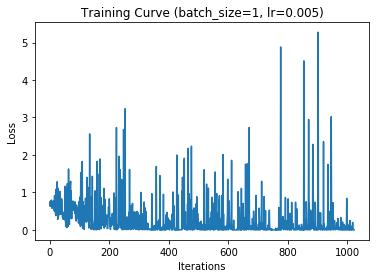

In [7]:
# only use the first 1024 images for training
mnist_data = datasets.MNIST('data', train=True, transform=img_to_tensor)
mnist_data = list(mnist_data)
mnist_train = mnist_data[:1024]

# create a new network with random weights, and optimizer for the network
pigeon = Pigeon()
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=1)
optimizer = optim.SGD(pigeon.parameters(), lr=0.005, momentum=0.9)

iters  = [] # save the iteration counts here for plotting
losses = [] # save the avg loss here for plotting

# training
for n, (imgs, labels) in enumerate(train_loader):
    actual = (labels < 3).reshape([1, 1]).type(torch.FloatTensor)
    out = pigeon(imgs)
    loss = criterion(out, actual) # compute the loss
    loss.backward()               # compute updates for each parameter
    optimizer.step()              # make the updates for each parameter
    optimizer.zero_grad()         # a clean up step for PyTorch

    # save the current training information
    iters.append(n)
    losses.append(float(loss))

# plotting
plt.plot(iters, losses)
plt.title("Training Curve (batch_size=1, lr=0.005)")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

The loss tends to improve very quickly near the beginning of training. To be able to better see the loss improvement towards the middle and end of the epoch, we can omit the first few iterations from our training curve:

Let's see how the training curve changes as we change the batch size and the learning rate. We will still plot one epoch of training with 1024 images, so that the comparison with the earlier plots is fair.

Since we'll be varying the batch size and learning rate, we'll write a function that plots the training curve.

In [8]:
def plot_training_curve(batch_size=1, lr=0.005): 
    """
    Plots the training curve on one epoch of training of the
    Pigeon network trained using the first 1024 images in
    the MNIST dataset.
    """

    pigeon = Pigeon()
    train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size)
    optimizer = optim.SGD(pigeon.parameters(), lr=lr, momentum=0.9)

    iters  = []
    losses = []

    # training
    for n, (imgs, labels) in enumerate(train_loader):
        actual = (labels < 3).reshape([batch_size, 1]) \
                            .type(torch.FloatTensor)
        out = pigeon(imgs)
        loss = criterion(out, actual) # compute the total loss
        loss.backward()               # compute updates for each parameter
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size) # compute *average* loss

    # plotting
    plt.plot(iters, losses)
    plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, lr))
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

Increasing the Batch Size
First, let's try a batch size of 32 and the same learning rate as before

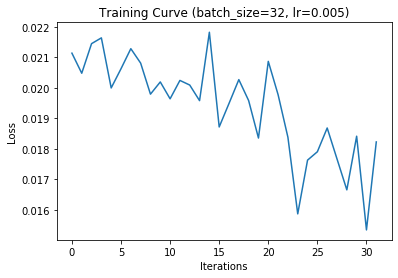

In [9]:
plot_training_curve(batch_size=32, lr=0.005)

The loss curve is a lot less noisy than before, and you can see that the network is still improving (the loss is still on a decline). Despite the general downward trend, the training loss can increase from time to time. Recall that in each iteration, we are computing the loss on a different mini-batch of training data.

Increasing the Learning Rate
Since we increased the batch size, we might be able to get away with a higher learning rate. Let's try.

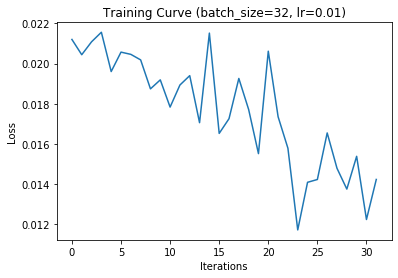

In [10]:
plot_training_curve(batch_size=32, lr=0.01)

The neural network trains much more quickly, and achieves a lower minimum loss.

Decreasing the Learning Rate
For comparison, here's what happens when we decrease the learning rate.

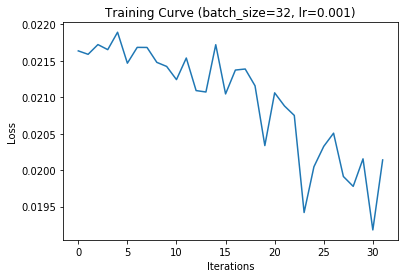

In [11]:
plot_training_curve(batch_size=32, lr=0.001)

Decreasing Learning Rate with Batch Size 1
If we keep the learning rate low, but have our batch size of 1, the noise is also reduced slightly.

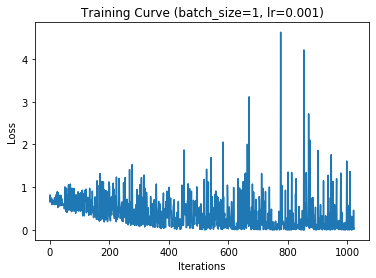

In [12]:
plot_training_curve(batch_size=1, lr=0.001)